In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Arguments 

In [2]:
corr = 0.25

# Load Model

In [3]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze_bigger_models")

epoch=24-val_loss=0.000703.ckpt


In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_988771/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [6]:
n_eval_envs = -1 #50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


In [7]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    outputs = []
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
            outputs.append(torch.argmax(out).item())
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states, outputs

# Across context decoding
(within-context is not that good)

In [8]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

    

In [9]:
train_envs = np.arange(1, int(n_eval_envs*0.9))
test_envs = np.arange(int(n_eval_envs*0.9), n_eval_envs)

def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": [],
        "layer": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        "maze_eighth": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        'next_state_feature': [],
        'action': [],
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
        seen_states = np.unique(seen_states, axis=0) 

        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > 800):
            continue

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        seq_length = 1000
        hidden_states, outputs = run_model(traj, model, seen_states, seq_length)
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_layer = goal_node.layer
        goal_pos = goal_node.pos
        for state_idx, state_feature in enumerate(seen_states):
            state_feature_tuple = tuple(state_feature.tolist())
            d = dist_from_goal[state_feature_tuple]
            layer = env.node_map[state_feature_tuple].layer
            pos = env.node_map[state_feature_tuple].pos
            node_identity = 2**layer + pos
            maze_half = get_subtree_location(layer, pos, 'half')
            maze_quarter = get_subtree_location(layer, pos, 'quarter')
            maze_eighth = get_subtree_location(layer, pos, 'eighth')
            action = outputs[state_idx]
            opt_action = np.zeros(4)
            opt_action[opt_action_map[state_feature_tuple]] = 1
            next_state_feature, _ = env.transit(state_feature, action)
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["layer"].append(layer)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["maze_eighth"].append(maze_eighth)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_layer, goal_pos, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_layer, goal_pos, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["next_state_feature"].append(next_state_feature)
            Ys_dict["action"].append(action)
            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx][0, -1].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()
    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

In [10]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True, plot=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

        if plot:
            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(3, 3))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-4, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()

    return pipelines, test_scores

In [11]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best alpha: 1.000
Train R2: 1.000
Test R2: 0.995



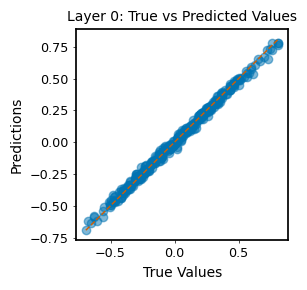

Layer 1:
Best alpha: 1.000
Train R2: 1.000
Test R2: 0.993



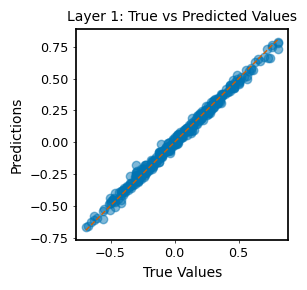

Layer 2:
Best alpha: 1.000
Train R2: 1.000
Test R2: 0.989



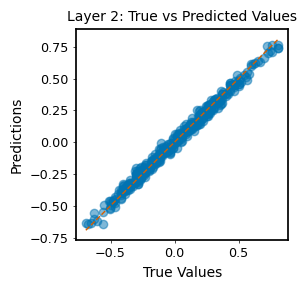

In [26]:
# Filter data to only include rows where opt_action is 1 or 2
filtered_X_train = [[] for _ in range(len(X_train))]
filtered_X_test = [[] for _ in range(len(X_test))]
filtered_Y_train = []
filtered_Y_test = []

# Filter training data
for i, action in enumerate(Ys_dict['opt_action']['Y_train']):
    if action in [1, 2]:
        for layer in range(len(X_train)):
            filtered_X_train[layer].append(X_train[layer][i])
        filtered_Y_train.append(Ys_dict["goal_state_feature"]["Y_train"][i])

# Filter test data
for i, action in enumerate(Ys_dict['opt_action']['Y_test']):
    if action in [1, 2]:
        for layer in range(len(X_test)):
            filtered_X_test[layer].append(X_test[layer][i])
        filtered_Y_test.append(Ys_dict["goal_state_feature"]["Y_test"][i])

# Run regression on filtered data
pipeline, test_score = fit_and_evaluate_regression(
    filtered_X_train, 
    filtered_Y_train, 
    filtered_X_test, 
    filtered_Y_test
)

Layer 0:
Best alpha: 3593.814
Train R2: 0.363
Test R2: 0.283



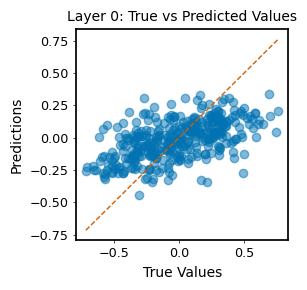

Layer 1:
Best alpha: 1291.550
Train R2: 0.442
Test R2: 0.287



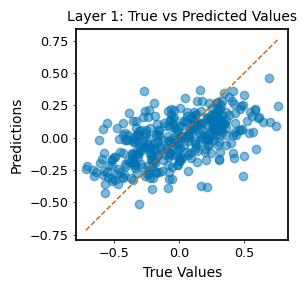

Layer 2:
Best alpha: 1291.550
Train R2: 0.440
Test R2: 0.270



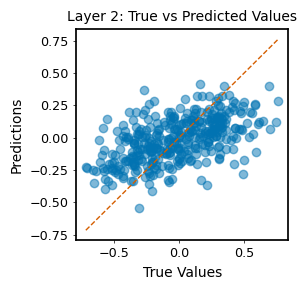

In [22]:
# Filter data to only include rows where opt_action is 1 or 2
filtered_X_train = [[] for _ in range(len(X_train))]
filtered_X_test = [[] for _ in range(len(X_test))]
filtered_Y_train = []
filtered_Y_test = []

# Filter training data
for i, action in enumerate(Ys_dict['opt_action']['Y_train']):
    if action in [1, 2]:
        for layer in range(len(X_train)):
            filtered_X_train[layer].append(X_train[layer][i])
        filtered_Y_train.append(Ys_dict["next_state_feature"]["Y_train"][i])

# Filter test data
for i, action in enumerate(Ys_dict['opt_action']['Y_test']):
    if action in [1, 2]:
        for layer in range(len(X_test)):
            filtered_X_test[layer].append(X_test[layer][i])
        filtered_Y_test.append(Ys_dict["next_state_feature"]["Y_test"][i])

# Run regression on filtered data
pipeline, test_score = fit_and_evaluate_regression(
    filtered_X_train, 
    filtered_Y_train, 
    filtered_X_test, 
    filtered_Y_test
)

Layer 0:
Best alpha: 1.000
Train R2: 1.000
Test R2: 0.999



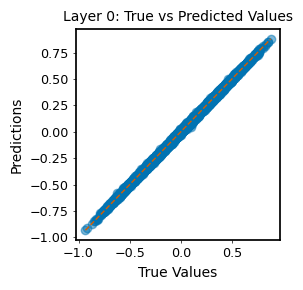

Layer 1:
Best alpha: 2.783
Train R2: 0.999
Test R2: 0.999



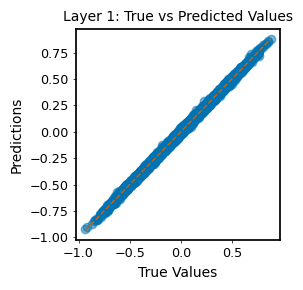

Layer 2:
Best alpha: 7.743
Train R2: 0.992
Test R2: 0.988



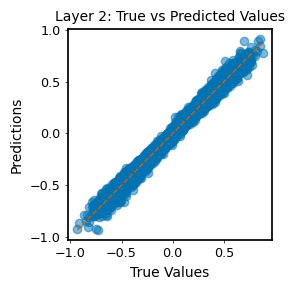

In [20]:
pipeline, test_score = fit_and_evaluate_regression(X_train, Ys_dict["state_feature"]["Y_train"], X_test, Ys_dict["state_feature"]["Y_test"])

Layer 0:
Best alpha: 21.544
Train R2: 0.494
Test R2: 0.365



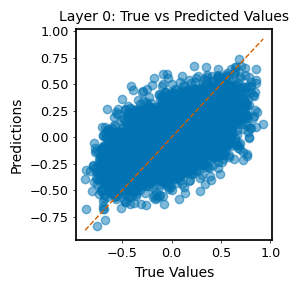

Layer 1:
Best alpha: 21.544
Train R2: 0.501
Test R2: 0.371



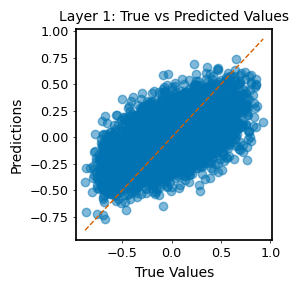

Layer 2:
Best alpha: 21.544
Train R2: 0.502
Test R2: 0.359



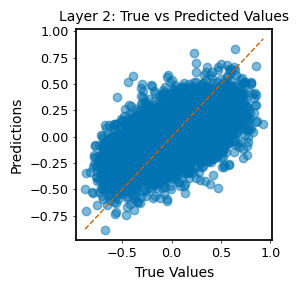

In [21]:
pipeline, test_score = fit_and_evaluate_regression(X_train, Ys_dict["next_state_feature"]["Y_train"], X_test, Ys_dict["next_state_feature"]["Y_test"])

Layer 0:
Best C: 0.001
Train Balanced Accuracy: 0.835
Test Balanced Accuracy: 0.834
Train Weighted F1: 0.808
Test Weighted F1: 0.814
Class distribution:
Class False: 5702 samples
Class True: 340 samples



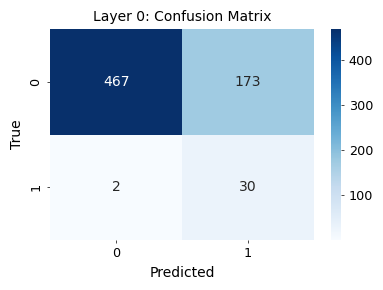

Layer 1:
Best C: 0.000
Train Balanced Accuracy: 0.814
Test Balanced Accuracy: 0.827
Train Weighted F1: 0.773
Test Weighted F1: 0.784
Class distribution:
Class False: 5702 samples
Class True: 340 samples



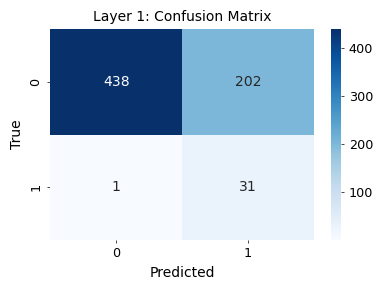

Layer 2:
Best C: 0.001
Train Balanced Accuracy: 0.992
Test Balanced Accuracy: 0.964
Train Weighted F1: 0.995
Test Weighted F1: 0.988
Class distribution:
Class False: 5702 samples
Class True: 340 samples



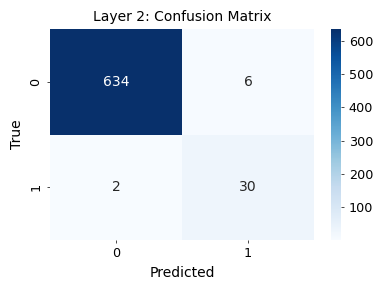

In [12]:
_Y_train = [a in [1, 2] for a in Ys_dict['opt_action']["Y_train"]]
_Y_test = [a in [1, 2] for a in Ys_dict['opt_action']["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test)

Layer 0:
Best C: 0.006
Train Balanced Accuracy: 0.675
Test Balanced Accuracy: 0.578
Train Weighted F1: 0.689
Test Weighted F1: 0.626
Class distribution:
Class False: 4445 samples
Class True: 1597 samples



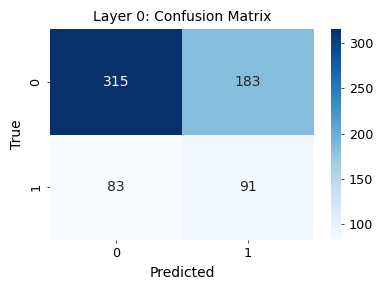

Layer 1:
Best C: 0.359
Train Balanced Accuracy: 0.789
Test Balanced Accuracy: 0.676
Train Weighted F1: 0.793
Test Weighted F1: 0.716
Class distribution:
Class False: 4445 samples
Class True: 1597 samples



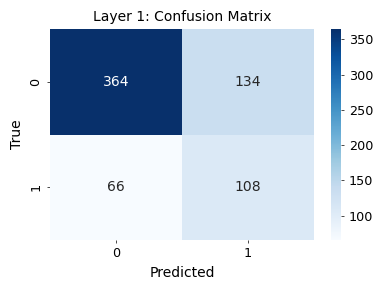

Layer 2:
Best C: 0.359
Train Balanced Accuracy: 0.819
Test Balanced Accuracy: 0.706
Train Weighted F1: 0.827
Test Weighted F1: 0.750
Class distribution:
Class False: 4445 samples
Class True: 1597 samples



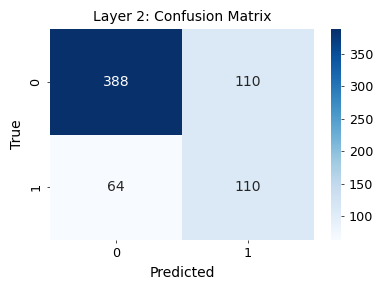

In [13]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_quarter_as_goal"]["Y_train"], X_test, Ys_dict["same_quarter_as_goal"]["Y_test"])

Layer 0:
Best alpha: 166.810
Train R2: 0.369
Test R2: 0.295



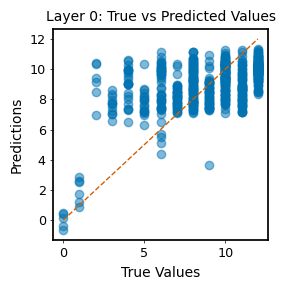

Layer 1:
Best alpha: 59.948
Train R2: 0.433
Test R2: 0.342



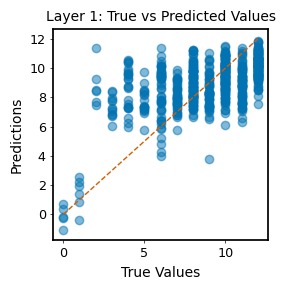

Layer 2:
Best alpha: 59.948
Train R2: 0.550
Test R2: 0.425



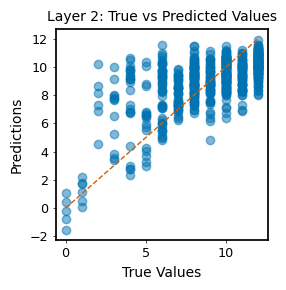

In [14]:
pipeline, test_score = fit_and_evaluate_regression(X_train, Ys_dict["dist_from_goal"]["Y_train"], X_test, Ys_dict["dist_from_goal"]["Y_test"])

Layer 0:
Best C: 0.000
Train Balanced Accuracy: 0.777
Test Balanced Accuracy: 0.761
Train Weighted F1: 0.764
Test Weighted F1: 0.769
Class distribution:
Class 0: 5660 samples
Class 1: 153 samples
Class 2: 172 samples
Class 3: 57 samples



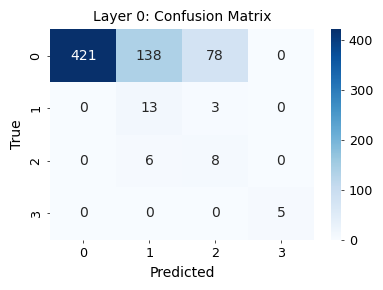

Layer 1:
Best C: 0.000
Train Balanced Accuracy: 0.786
Test Balanced Accuracy: 0.761
Train Weighted F1: 0.759
Test Weighted F1: 0.763
Class distribution:
Class 0: 5660 samples
Class 1: 153 samples
Class 2: 172 samples
Class 3: 57 samples



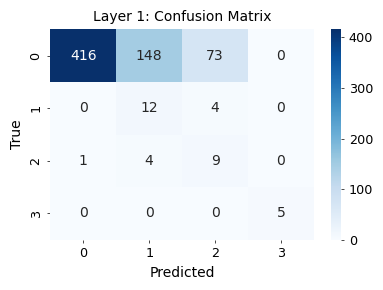

Layer 2:
Best C: 0.006
Train Balanced Accuracy: 1.000
Test Balanced Accuracy: 1.000
Train Weighted F1: 0.999
Test Weighted F1: 1.000
Class distribution:
Class 0: 5660 samples
Class 1: 153 samples
Class 2: 172 samples
Class 3: 57 samples



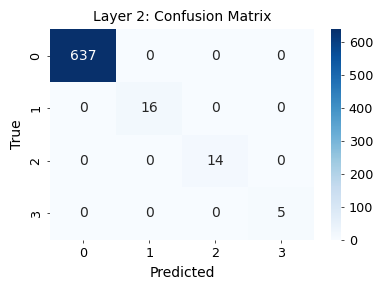

In [15]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["action"]["Y_train"], X_test, Ys_dict["action"]["Y_test"])

Layer 0:
Best C: 0.006
Train Balanced Accuracy: 0.675
Test Balanced Accuracy: 0.578
Train Weighted F1: 0.689
Test Weighted F1: 0.626
Class distribution:
Class False: 4445 samples
Class True: 1597 samples



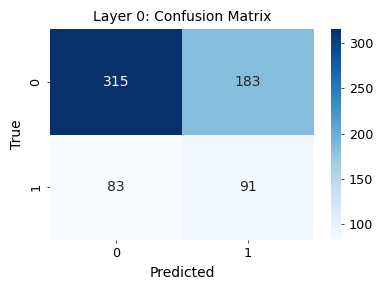

Layer 1:
Best C: 0.359
Train Balanced Accuracy: 0.789
Test Balanced Accuracy: 0.676
Train Weighted F1: 0.793
Test Weighted F1: 0.716
Class distribution:
Class False: 4445 samples
Class True: 1597 samples



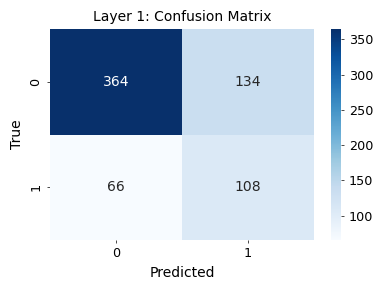

Layer 2:
Best C: 0.359
Train Balanced Accuracy: 0.819
Test Balanced Accuracy: 0.706
Train Weighted F1: 0.827
Test Weighted F1: 0.750
Class distribution:
Class False: 4445 samples
Class True: 1597 samples



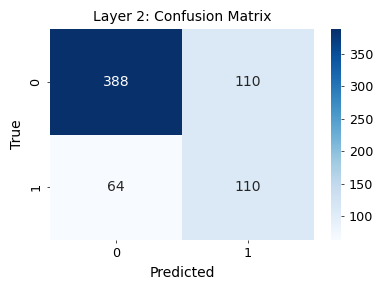

In [16]:
pipeline, test_score = fit_and_evaluate_classification(
    X_train, Ys_dict["same_quarter_as_goal"]["Y_train"], X_test, Ys_dict["same_quarter_as_goal"]["Y_test"])

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Layer 0:
Best C: 0.000
Train Balanced Accuracy: 0.483
Test Balanced Accuracy: 0.406
Train Weighted F1: 0.543
Test Weighted F1: 0.544
Class distribution:
Class 0: 54 samples
Class 1: 110 samples
Class 2: 209 samples
Class 3: 432 samples
Class 4: 822 samples
Class 5: 1559 samples
Class 6: 2856 samples



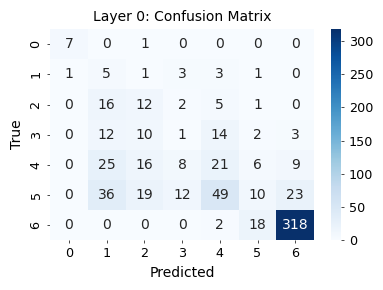

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Layer 1:
Best C: 0.000
Train Balanced Accuracy: 0.475
Test Balanced Accuracy: 0.398
Train Weighted F1: 0.539
Test Weighted F1: 0.551
Class distribution:
Class 0: 54 samples
Class 1: 110 samples
Class 2: 209 samples
Class 3: 432 samples
Class 4: 822 samples
Class 5: 1559 samples
Class 6: 2856 samples



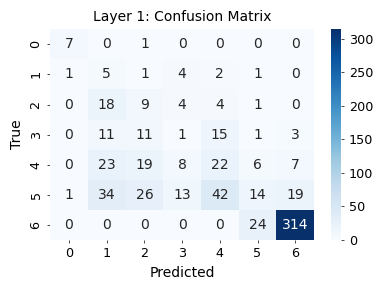

Layer 2:
Best C: 0.000
Train Balanced Accuracy: 0.517
Test Balanced Accuracy: 0.469
Train Weighted F1: 0.631
Test Weighted F1: 0.622
Class distribution:
Class 0: 54 samples
Class 1: 110 samples
Class 2: 209 samples
Class 3: 432 samples
Class 4: 822 samples
Class 5: 1559 samples
Class 6: 2856 samples



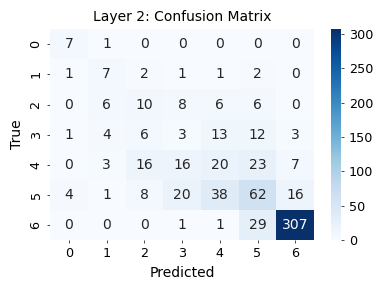

In [17]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["layer"]["Y_train"], X_test, Ys_dict["layer"]["Y_test"])

Layer 0:
Best C: 0.046
Train Balanced Accuracy: 0.785
Test Balanced Accuracy: 0.680
Train Weighted F1: 0.680
Test Weighted F1: 0.585
Class distribution:
Class 0: 54 samples
Class 1: 2999 samples
Class 2: 2989 samples



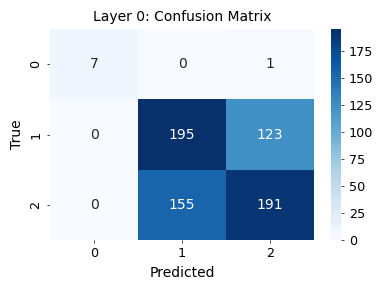

Layer 1:
Best C: 0.359
Train Balanced Accuracy: 0.826
Test Balanced Accuracy: 0.708
Train Weighted F1: 0.741
Test Weighted F1: 0.628
Class distribution:
Class 0: 54 samples
Class 1: 2999 samples
Class 2: 2989 samples



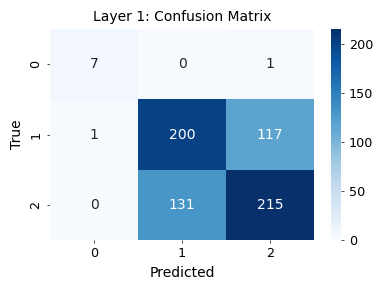

Layer 2:
Best C: 2.783
Train Balanced Accuracy: 0.854
Test Balanced Accuracy: 0.718
Train Weighted F1: 0.783
Test Weighted F1: 0.642
Class distribution:
Class 0: 54 samples
Class 1: 2999 samples
Class 2: 2989 samples



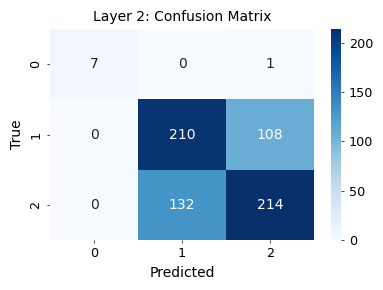

In [18]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_half"]["Y_train"], X_test, Ys_dict["maze_half"]["Y_test"])

Layer 0:
Best C: 0.359
Train Balanced Accuracy: 0.638
Test Balanced Accuracy: 0.331
Train Weighted F1: 0.559
Test Weighted F1: 0.311
Class distribution:
Class 0: 164 samples
Class 1: 1479 samples
Class 2: 1466 samples
Class 3: 1477 samples
Class 4: 1456 samples



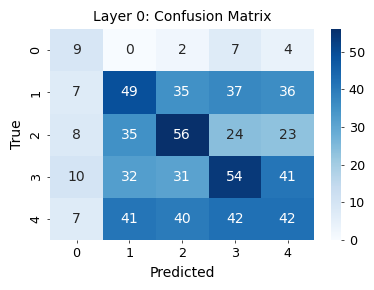

Layer 1:
Best C: 0.359
Train Balanced Accuracy: 0.675
Test Balanced Accuracy: 0.377
Train Weighted F1: 0.603
Test Weighted F1: 0.349
Class distribution:
Class 0: 164 samples
Class 1: 1479 samples
Class 2: 1466 samples
Class 3: 1477 samples
Class 4: 1456 samples



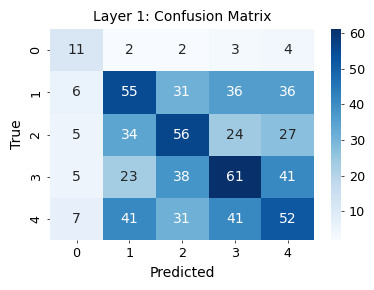

Layer 2:
Best C: 0.359
Train Balanced Accuracy: 0.703
Test Balanced Accuracy: 0.452
Train Weighted F1: 0.638
Test Weighted F1: 0.403
Class distribution:
Class 0: 164 samples
Class 1: 1479 samples
Class 2: 1466 samples
Class 3: 1477 samples
Class 4: 1456 samples



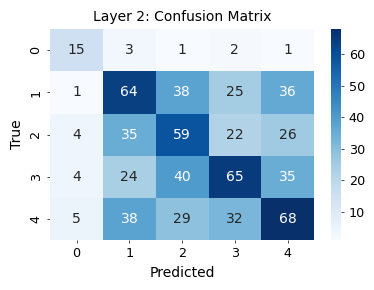

In [19]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_quarter"]["Y_train"], X_test, Ys_dict["maze_quarter"]["Y_test"])

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Layer 0:
Best C: 2.783
Train Balanced Accuracy: 0.641
Test Balanced Accuracy: 0.220
Train Weighted F1: 0.620
Test Weighted F1: 0.211
Class distribution:
Class 0: 373 samples
Class 1: 711 samples
Class 2: 716 samples
Class 3: 727 samples
Class 4: 692 samples
Class 5: 683 samples
Class 6: 738 samples
Class 7: 675 samples
Class 8: 727 samples



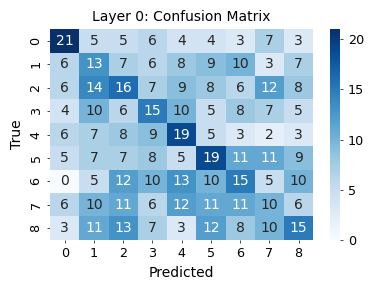

/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Layer 1:
Best C: 2.783
Train Balanced Accuracy: 0.689
Test Balanced Accuracy: 0.235
Train Weighted F1: 0.671
Test Weighted F1: 0.227
Class distribution:
Class 0: 373 samples
Class 1: 711 samples
Class 2: 716 samples
Class 3: 727 samples
Class 4: 692 samples
Class 5: 683 samples
Class 6: 738 samples
Class 7: 675 samples
Class 8: 727 samples



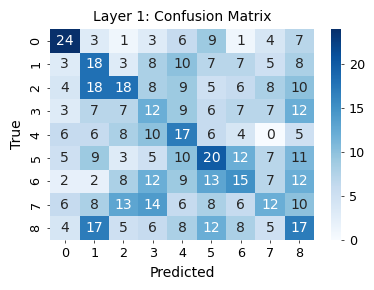

Layer 2:
Best C: 2.783
Train Balanced Accuracy: 0.723
Test Balanced Accuracy: 0.262
Train Weighted F1: 0.708
Test Weighted F1: 0.257
Class distribution:
Class 0: 373 samples
Class 1: 711 samples
Class 2: 716 samples
Class 3: 727 samples
Class 4: 692 samples
Class 5: 683 samples
Class 6: 738 samples
Class 7: 675 samples
Class 8: 727 samples



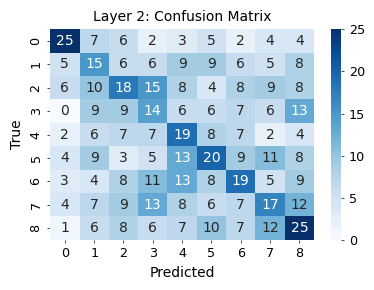

In [20]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_eighth"]["Y_train"], X_test, Ys_dict["maze_eighth"]["Y_test"])

Layer 0:
Best C: 0.000
Train Balanced Accuracy: 0.777
Test Balanced Accuracy: 0.761
Train Weighted F1: 0.764
Test Weighted F1: 0.769
Class distribution:
Class 0: 5660 samples
Class 1: 153 samples
Class 2: 172 samples
Class 3: 57 samples



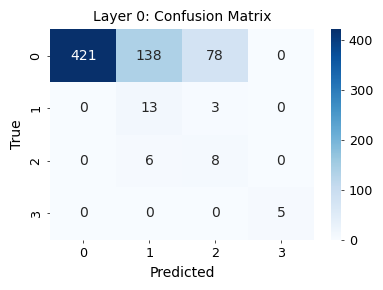

Layer 1:
Best C: 0.000
Train Balanced Accuracy: 0.786
Test Balanced Accuracy: 0.761
Train Weighted F1: 0.759
Test Weighted F1: 0.763
Class distribution:
Class 0: 5660 samples
Class 1: 153 samples
Class 2: 172 samples
Class 3: 57 samples



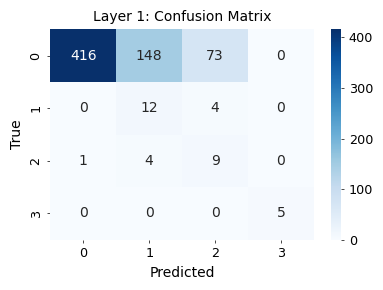

Layer 2:
Best C: 0.006
Train Balanced Accuracy: 1.000
Test Balanced Accuracy: 1.000
Train Weighted F1: 0.999
Test Weighted F1: 1.000
Class distribution:
Class 0: 5660 samples
Class 1: 153 samples
Class 2: 172 samples
Class 3: 57 samples



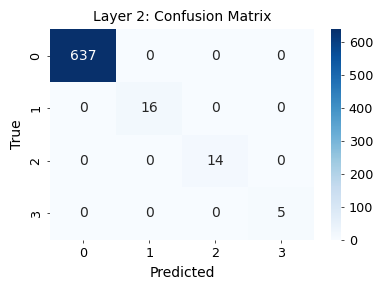

In [21]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["action"]["Y_train"], X_test, Ys_dict["action"]["Y_test"])